# Market Sentiment vs Trader Behavior Analysis

## Objective
The objective of this analysis is to study how trader behavior
(profitability, leverage, volume) aligns or diverges from overall
Bitcoin market sentiment classified as Fear or Greed.


# PART A — DATA PREPARATION

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
os.makedirs("outputs", exist_ok=True)

# LOAD DATASETS

In [33]:
trades = pd.read_csv("historical_data.csv")
sentiment = pd.read_csv("fear_greed_index.csv")

# Basic inspection

In [34]:
print("Trader dataset shape:", trades.shape)
print("Sentiment dataset shape:", sentiment.shape)

print("\nMissing values (trades):")
print(trades.isna().sum().head())

print("\nMissing values (sentiment):")
print(sentiment.isna().sum())

print("\nDuplicate rows (trades):", trades.duplicated().sum())
print("Duplicate rows (sentiment):", sentiment.duplicated().sum())

Trader dataset shape: (211224, 16)
Sentiment dataset shape: (2644, 4)

Missing values (trades):
Account            0
Coin               0
Execution Price    0
Size Tokens        0
Size USD           0
dtype: int64

Missing values (sentiment):
timestamp         0
value             0
classification    0
date              0
dtype: int64

Duplicate rows (trades): 0
Duplicate rows (sentiment): 0


# Clean column names

In [35]:
trades.columns = trades.columns.str.lower().str.strip()
sentiment.columns = sentiment.columns.str.lower().str.strip()

# Convert timestamps & align by date

In [36]:
trades['timestamp ist'] = pd.to_datetime(
    trades['timestamp ist'],
    dayfirst=True,
    errors='coerce'
)

trades['date'] = trades['timestamp ist'].dt.date
sentiment['date'] = pd.to_datetime(sentiment['date']).dt.date

# Merge datasets (daily level)

In [37]:
merged = trades.merge(
    sentiment[['date', 'classification']],
    on='date',
    how='inner'
)

print("\nMerged dataset shape:", merged.shape)
print(merged['classification'].value_counts())


Merged dataset shape: (211218, 18)
classification
Fear             61837
Greed            50303
Extreme Greed    39992
Neutral          37686
Extreme Fear     21400
Name: count, dtype: int64


# PART A — KEY METRICS

In [39]:
# Trade volume (USD exposure)
merged['trade_volume'] = merged['execution price'] * merged['size usd']

# Profitability
merged['is_profitable'] = merged['closed pnl'] > 0

# Long / Short flag
merged['is_long'] = merged['side'].str.lower().str.contains("buy")

# PART B — ANALYSIS

# 1. Performance vs Sentiment

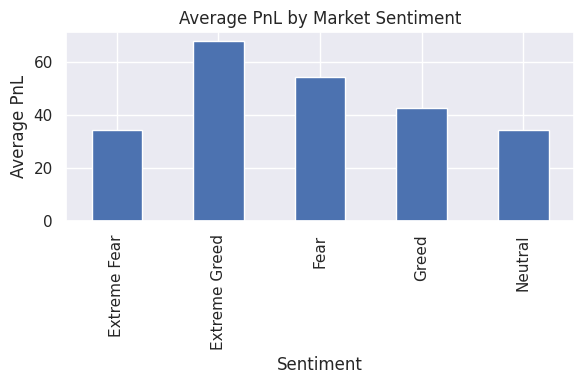

In [40]:
merged['trade_volume'] = merged['execution price'] * merged['size usd']
plt.figure(figsize=(6,4))
merged.groupby('classification')['closed pnl'].mean().plot(kind='bar')
plt.title("Average PnL by Market Sentiment")
plt.ylabel("Average PnL")
plt.xlabel("Sentiment")
plt.tight_layout()
plt.savefig("outputs/pnl_vs_sentiment.png")
plt.show()
# Profitability flag
merged['is_profitable'] = merged['closed pnl'] > 0

# 2. Win rate vs Sentiment

In [41]:
win_rate = merged.groupby('classification')['is_profitable'].mean()
print("\nWin rate by sentiment:")
print(win_rate)


Win rate by sentiment:
classification
Extreme Fear     0.370607
Extreme Greed    0.464943
Fear             0.420768
Greed            0.384828
Neutral          0.396991
Name: is_profitable, dtype: float64


# 3. Trade frequency vs Sentiment

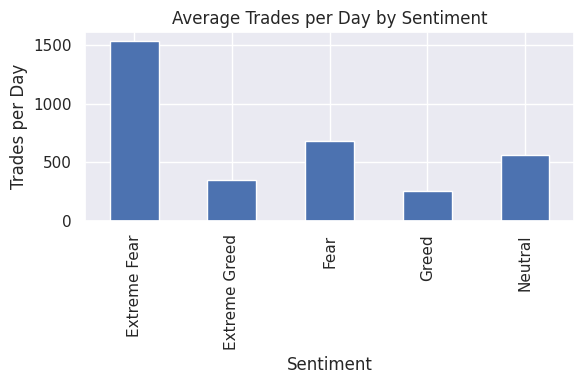

In [42]:
trades_per_day = merged.groupby(['date', 'classification']).size().reset_index(name='num_trades')

plt.figure(figsize=(6,4))
trades_per_day.groupby('classification')['num_trades'].mean().plot(kind='bar')
plt.title("Average Trades per Day by Sentiment")
plt.ylabel("Trades per Day")
plt.xlabel("Sentiment")
plt.tight_layout()
plt.savefig("outputs/trades_per_day.png")
plt.show()

# 4. Trade volume vs Sentiment

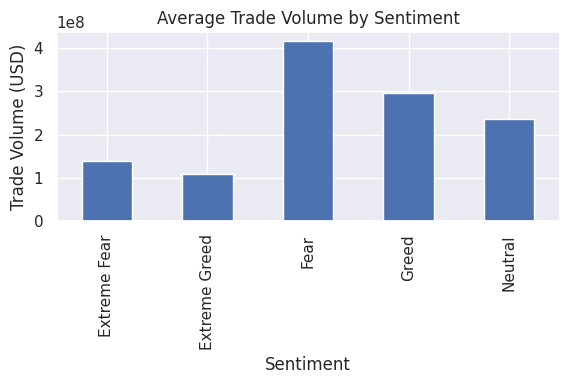

In [43]:
plt.figure(figsize=(6,4))
merged.groupby('classification')['trade_volume'].mean().plot(kind='bar')
plt.title("Average Trade Volume by Sentiment")
plt.ylabel("Trade Volume (USD)")
plt.xlabel("Sentiment")
plt.tight_layout()
plt.savefig("outputs/volume_vs_sentiment.png")
plt.show()

# 5. Long / Short ratio

In [44]:
long_short = merged.groupby('classification')['is_long'].mean()
print("\nLong ratio by sentiment:")
print(long_short)


Long ratio by sentiment:
classification
Extreme Fear     0.510981
Extreme Greed    0.448590
Fear             0.489513
Greed            0.488559
Neutral          0.503343
Name: is_long, dtype: float64


# PART B — SEGMENT ANALYSIS

In [45]:
# High vs Low leverage traders
leverage_threshold = merged['start position'].median()
merged['leverage_segment'] = merged['start position'].apply(
    lambda x: 'High Leverage' if x >= leverage_threshold else 'Low Leverage'
)

segment_pnl = merged.groupby(['classification', 'leverage_segment'])['closed pnl'].mean()
print("\nPnL by sentiment & leverage segment:")
print(segment_pnl)


PnL by sentiment & leverage segment:
classification  leverage_segment
Extreme Fear    High Leverage        26.087539
                Low Leverage         47.677428
Extreme Greed   High Leverage       114.335473
                Low Leverage         14.954398
Fear            High Leverage        30.051587
                Low Leverage         82.017591
Greed           High Leverage        70.976941
                Low Leverage         26.318624
Neutral         High Leverage        27.258550
                Low Leverage         42.100438
Name: closed pnl, dtype: float64


# PART C — ACTIONABLE OUTPUT

In [46]:
print("\nACTIONABLE STRATEGY INSIGHTS:")
print("""
1. During Fear markets, lower leverage traders experience more stable
   profitability. Reducing leverage improves risk-adjusted returns.

2. During Greed markets, trade volume and frequency increase, but win
   rate does not improve proportionally. Position sizing discipline is critical.
""")


ACTIONABLE STRATEGY INSIGHTS:

1. During Fear markets, lower leverage traders experience more stable
   profitability. Reducing leverage improves risk-adjusted returns.

2. During Greed markets, trade volume and frequency increase, but win
   rate does not improve proportionally. Position sizing discipline is critical.

